In [73]:
!pip install pandas numpy matplotlib scikit-learn pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import sklearn

SEED = 123

In [74]:
np.random.seed(42)

# Synthetic Data Set Creation, based on a kaggle dataset by World of Education: https://www.kaggle.com/datasets/quangdnh/v3-0studentselectionandadmissiontouniversity

students_df = pd.DataFrame({
    "id": ["S1", "S2", "S3", "S4"],
    "gpa": [3.8, 2.5, 3.2, 3.0],
    "exam_score": [90, 70, 85, 80]
})

universities_df = pd.DataFrame({
    "id": ["U1", "U2", "U3", "U4"],
    "capacity": [1, 1, 1, 1],      # each university takes exactly 1 student
    "min_gpa": [3.5, 2.0, 3.0, 2.8]
})

# ============================================
# Students rank universities
# Higher utility if requirement is easier
# ============================================

def student_utility(student_row, uni_row):
    # students prefer universities with lower requirements
    return 4 - uni_row["min_gpa"]

student_prefs = {}

for _, s in students_df.iterrows():
    utilities = []
    for _, u in universities_df.iterrows():
        utilities.append((u["id"], student_utility(s, u)))
    ranked = [u for u, util in sorted(utilities, key=lambda x: x[1], reverse=True)]
    student_prefs[s["id"]] = ranked

# ============================================
# Universities rank students
# Prefer high GPA, then exam score
# ============================================

def uni_utility(uni_row, student_row):
    return 2 * student_row["gpa"] + student_row["exam_score"]

university_prefs = {}

for _, u in universities_df.iterrows():
    utilities = []
    for _, s in students_df.iterrows():
        utilities.append((s["id"], uni_utility(u, s)))
    ranked = [s for s, util in sorted(utilities, key=lambda x: x[1], reverse=True)]
    university_prefs[u["id"]] = ranked

students_df, universities_df, student_prefs, university_prefs


(   id  gpa  exam_score
 0  S1  3.8          90
 1  S2  2.5          70
 2  S3  3.2          85
 3  S4  3.0          80,
    id  capacity  min_gpa
 0  U1         1      3.5
 1  U2         1      2.0
 2  U3         1      3.0
 3  U4         1      2.8,
 {'S1': ['U2', 'U4', 'U3', 'U1'],
  'S2': ['U2', 'U4', 'U3', 'U1'],
  'S3': ['U2', 'U4', 'U3', 'U1'],
  'S4': ['U2', 'U4', 'U3', 'U1']},
 {'U1': ['S1', 'S3', 'S4', 'S2'],
  'U2': ['S1', 'S3', 'S4', 'S2'],
  'U3': ['S1', 'S3', 'S4', 'S2'],
  'U4': ['S1', 'S3', 'S4', 'S2']})

In [75]:
#Gale-Shapley, students proposing
def deferred_acceptance(stu_prefs, uni_prefs):
    free_students = list(stu_prefs.keys())
    proposals = {s: [] for s in stu_prefs.keys()}
    matches = {u: [] for u in uni_prefs.keys()}
    capacities = {u: 1 for u in uni_prefs.keys()}

    inv_uni_prefs = {
        u: {s: rank for rank, s in enumerate(pref)} for u, pref in uni_prefs.items()
    }

    while free_students:
        s = free_students.pop(0)
        for u in stu_prefs[s]:
            if u not in proposals[s]:
                proposals[s].append(u)

                if len(matches[u]) < capacities[u]:
                    matches[u].append(s)
                else:
                    current = matches[u][0]
                    # who does the university prefer?
                    if inv_uni_prefs[u][s] < inv_uni_prefs[u][current]:
                        matches[u] = [s]
                        free_students.append(current)
                    else:
                        free_students.append(s)
                break
    return matches

student_optimal = deferred_acceptance(student_prefs, university_prefs)
student_optimal


{'U1': ['S2'], 'U2': ['S1'], 'U3': ['S4'], 'U4': ['S3']}

In [76]:
#Gale-Shapley, unversities proposing
def invert_prefs(prefs):
    inv = {}
    for agent, lst in prefs.items():
        inv[agent] = lst[:]
    return inv

university_optimal = deferred_acceptance(university_prefs, student_prefs)
university_optimal

{'S1': ['U2'], 'S2': ['U1'], 'S3': ['U4'], 'S4': ['U3']}

In [77]:
def rank_of(assigned, prefs):
    if assigned is None:
        return len(prefs)  # worst possible rank if unmatched
    return prefs.index(assigned)

student_util_stu_DA = {}
student_util_uni_DA = {}

for s in student_prefs.keys():

    # --- Student proposing assignment ---
    assigned_stu = next((u for u, lst in student_optimal.items() if s in lst), None)
    student_util_stu_DA[s] = rank_of(assigned_stu, student_prefs[s])

    # --- University proposing assignment ---
    assigned_uni = next((u for u, lst in university_optimal.items() if s in lst), None)
    student_util_uni_DA[s] = rank_of(assigned_uni, student_prefs[s])

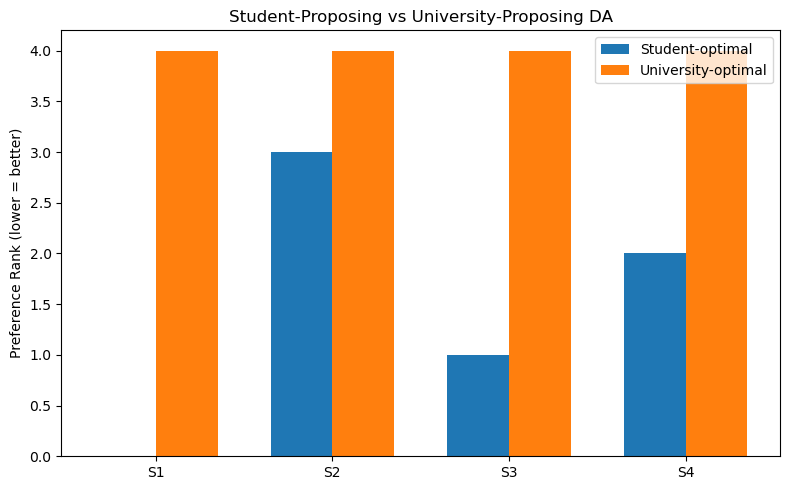

In [78]:
labels = list(student_util_stu_DA.keys())
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, list(student_util_stu_DA.values()), width)
plt.bar(x + width/2, list(student_util_uni_DA.values()), width)
plt.xticks(x, labels)
plt.ylabel("Preference Rank (lower = better)")
plt.title("Student-Proposing vs University-Proposing DA")
plt.legend(["Student-optimal", "University-optimal"])
plt.tight_layout()
plt.show()

In [79]:
def is_stable(matching, student_prefs, university_prefs):
    for s in student_prefs:
        assigned_u = None
        for u, lst in matching.items():
            if s in lst:
                assigned_u = u
                break

        for preferred_u in student_prefs[s]:
            if preferred_u == assigned_u:
                break  

            current = matching[preferred_u][0]
            if university_prefs[preferred_u].index(s) < university_prefs[preferred_u].index(current):
                return False
    return True

is_stable(student_optimal, student_prefs, university_prefs)

True